In [1]:
# --- BLOQUE 1: Lectura de Google Sheets (compatible Colab + GitHub Actions) ---
import os, json
import pandas as pd
from google.oauth2 import service_account
from googleapiclient.discovery import build

def _load_credentials():
    """
    Intenta credenciales en este orden:
    1) Colab userdata (MI_JSON)
    2) Variable de entorno (MI_JSON) -> GitHub Actions
    3) Archivo local MI_JSON.json (opcional, para correr en tu PC)
    """
    # 1) Colab
    try:
        from google.colab import userdata  # noqa: F401
        mi_json = userdata.get("MI_JSON")
        if mi_json:
            info = json.loads(mi_json) if mi_json.strip().startswith("{") else json.loads(mi_json.strip().replace("'", '"'))
            return service_account.Credentials.from_service_account_info(info)
    except Exception:
        pass

    # 2) GitHub Actions / Local via env var
    if os.getenv("MI_JSON"):
        info = json.loads(os.environ["MI_JSON"])
        return service_account.Credentials.from_service_account_info(info)

    # 3) Archivo local
    if os.path.exists("MI_JSON.json"):
        return service_account.Credentials.from_service_account_file("MI_JSON.json")

    raise RuntimeError("No encontré credenciales. Carga MI_JSON (secret/env) o MI_JSON.json local.")

# === Crear servicio de Google Sheets ===
creds = _load_credentials()
service = build("sheets", "v4", credentials=creds)

# === URL y hoja ===
sheet_url = "https://docs.google.com/spreadsheets/d/1xGSzneJkRqREZupLshG9jaNK8wbP8WpV-yjUs_Lm7AA"
sheet_id = sheet_url.split("/")[5]
sheet_name = "ORGINACIONES_UNICAS"

# === Leer los datos ===
result = service.spreadsheets().values().get(
    spreadsheetId=sheet_id,
    range=f"{sheet_name}!A:Z"  # ajusta el rango si necesitas más columnas
).execute()

data = result.get("values", [])

# === Convertir a DataFrame (sin display en headless) ===
if not data:
    raise ValueError(f"No se encontraron datos en la hoja '{sheet_name}'.")

df = pd.DataFrame(data[1:], columns=data[0])
print(f"✅ DataFrame '{sheet_name}' cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")
print(df.head(3).to_string(index=False))

/opt/hostedtoolcache/Python/3.10.19/x64/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


✅ DataFrame 'ORGINACIONES_UNICAS' cargado con 4585 filas y 8 columnas.
REFERENCIA COHORTE_FINAL AMOUNT_TOTAL   PAGO PRI-ULT       Ratio_PP           C/A   recaudo_real
1001082965    Recuperado  579646917.6 689780       2 0.001014816058 0.04136807356  0.00119000029
1001082965    Recuperado  401562742.8 477860       1 0.001442872902             0 0.001190000837
1001082965    INCOBRABLE  138405056.1 624732       5  0.00364901409   0.983461671 0.004513794636


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4585 entries, 0 to 4584
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   REFERENCIA     4585 non-null   object
 1   COHORTE_FINAL  4585 non-null   object
 2   AMOUNT_TOTAL   4585 non-null   object
 3   PAGO           4585 non-null   object
 4   PRI-ULT        4585 non-null   object
 5   Ratio_PP       4585 non-null   object
 6   C/A            4585 non-null   object
 7   recaudo_real   4585 non-null   object
dtypes: object(8)
memory usage: 286.7+ KB


In [3]:
import pandas as pd
import numpy as np

# === Columnas a convertir ===
cols_numericas = ["AMOUNT_TOTAL", "PAGO", "PRI-ULT", "Ratio_PP", "C/A", "recaudo_real"]

# === Convertir a float de forma segura ===
for col in cols_numericas:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)              # convierte todo a texto
            .str.replace(',', '', regex=False)  # elimina comas (por si acaso hay separadores de miles)
            .str.replace(' ', '', regex=False)  # elimina espacios
            .replace(['', 'nan', 'None'], np.nan)  # convierte vacíos en NaN
            .astype(float)             # convierte a float
        )
    else:
        print(f"⚠️ No se encontró la columna '{col}' en el DataFrame.")

print("✅ Conversión completada. Tipos de datos actuales:")
print(df.dtypes)

✅ Conversión completada. Tipos de datos actuales:
REFERENCIA        object
COHORTE_FINAL     object
AMOUNT_TOTAL     float64
PAGO             float64
PRI-ULT          float64
Ratio_PP         float64
C/A              float64
recaudo_real     float64
dtype: object


In [4]:
df

,REFERENCIA,COHORTE_FINAL,AMOUNT_TOTAL,PAGO,PRI-ULT,Ratio_PP,C/A,recaudo_real
0,1001082965,Recuperado,5.796469e+08,689780.0,2.0,0.001015,0.041368,0.001190
1,1001082965,Recuperado,4.015627e+08,477860.0,1.0,0.001443,0.000000,0.001190
2,1001082965,INCOBRABLE,1.384051e+08,624732.0,5.0,0.003649,0.983462,0.004514
3,1001244516,Siempre Al día,8.235188e+07,979988.0,6.0,0.002206,1.681689,0.011900
4,1001833139,Siempre Al día,2.602366e+08,976050.0,2.0,0.000383,1.222307,0.003751
...,...,...,...,...,...,...,...,...
4580,98501254,Siempre Al día,2.872770e+08,341860.0,2.0,0.001190,0.262692,0.001190
4581,98501254,Siempre Al día,2.402840e+08,2859380.0,1.0,0.011900,1.871878,0.011900
4582,98702966,Recuperado,1.663798e+08,1979921.0,6.0,0.001192,0.850184,0.011900
4583,98702966,Mora vigente,1.288348e+08,6078401.0,17.0,0.010462,1.045447,0.047180


In [5]:
import io
import json
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

# Si deseas asegurar zona horaria específica (ej. Bogotá), descomenta estas dos líneas:
# from zoneinfo import ZoneInfo
# TZ = ZoneInfo("America/Bogota")

# ================== 1) Credenciales (Colab/GitHub) ==================
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
]

def get_creds():
    try:
        # Colab
        from google.colab import userdata
        mi_json = userdata.get("MI_JSON")
        if not mi_json:
            raise RuntimeError("MI_JSON vacío en Colab")
        # Más seguro que eval:
        info = json.loads(mi_json)
        return service_account.Credentials.from_service_account_info(info, scopes=SCOPES)
    except Exception:
        # GitHub / local: coloca tu archivo en el repo
        return service_account.Credentials.from_service_account_file("MI_JSON.json", scopes=SCOPES)

def get_services():
    creds = get_creds()
    sheets = build("sheets", "v4", credentials=creds)
    drive = build("drive", "v3", credentials=creds)
    return sheets, drive

# ================== 2) Utilidades ==================
MESES_ES = ["Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]
CUTOFF_DIA = 6  # Hasta el día 6 del mes siguiente, cuenta como mes anterior

def _norm(s: str) -> str:
    return " ".join(str(s).strip().split()).casefold()

def mes_logico_y_anio(dt: datetime, cutoff: int = CUTOFF_DIA):
    """
    Regla: si el día del mes es <= cutoff, usar el mes anterior; si no, usar el mes actual.
    Maneja el cambio de año (enero -> diciembre del año anterior).
    """
    # Si usas zona horaria fija:
    # if dt.tzinfo is None:
    #     dt = dt.replace(tzinfo=TZ)
    # else:
    #     dt = dt.astimezone(TZ)

    if dt.day <= cutoff:
        if dt.month == 1:
            return 12, dt.year - 1
        else:
            return dt.month - 1, dt.year
    else:
        return dt.month, dt.year

def nombre_hoja_actual(dt: datetime | None = None, cutoff: int = CUTOFF_DIA) -> str:
    """
    Devuelve el nombre de la hoja en formato 'Mes Año' aplicando la regla del cutoff.
    """
    if dt is None:
        dt = datetime.now()  # .astimezone(TZ) si deseas forzar zona horaria
    mes, anio = mes_logico_y_anio(dt, cutoff)
    return f"{MESES_ES[mes-1]} {anio}"

def resolve_file_id(drive, file_id: str) -> dict:
    """Resuelve shortcuts y devuelve metadatos del archivo final."""
    meta = drive.files().get(fileId=file_id, fields="id,name,mimeType,shortcutDetails").execute()
    if meta.get("mimeType") == "application/vnd.google-apps.shortcut":
        target = meta["shortcutDetails"]["targetId"]
        meta = drive.files().get(fileId=target, fields="id,name,mimeType").execute()
    return meta

def download_excel_as_bytes(drive, file_id: str) -> bytes:
    request = drive.files().get_media(fileId=file_id)
    buf = io.BytesIO()
    downloader = MediaIoBaseDownload(buf, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
    buf.seek(0)
    return buf.read()

# ================== 3) Lector universal ==================
def leer_mes_actual(sheet_url: str, rango="A:ZZ", cutoff: int = CUTOFF_DIA):
    sheets, drive = get_services()
    file_id = sheet_url.split("/")[5]
    meta = resolve_file_id(drive, file_id)
    mime = meta["mimeType"]

    objetivo = nombre_hoja_actual(cutoff=cutoff)
    objetivo_norm = _norm(objetivo)

    if mime == "application/vnd.google-apps.spreadsheet":
        # ---- Google Sheets nativo ----
        # 1) listar pestañas
        meta_sheet = sheets.spreadsheets().get(spreadsheetId=meta["id"]).execute()
        titulos = [s["properties"]["title"] for s in meta_sheet["sheets"]]

        # 2) elegir pestaña por nombre (exacto o contiene)
        candidatos = {t: _norm(t) for t in titulos}
        match = next((t for t, n in candidatos.items() if n == objetivo_norm), None)
        if not match:
            match = next((t for t in titulos if objetivo_norm in _norm(t)), None)
        if not match:
            raise ValueError(f"No encontré una pestaña '{objetivo}'. Pestañas: {', '.join(titulos)}")

        # 3) leer valores
        resp = sheets.spreadsheets().values().get(
            spreadsheetId=meta["id"], range=f"{match}!{rango}"
        ).execute()
        data = resp.get("values", [])
        if not data:
            raise ValueError(f"La hoja '{match}' no tiene datos.")
        df = pd.DataFrame(data[1:], columns=data[0])
        return df, match, meta["name"], objetivo

    elif mime in (
        "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet",  # .xlsx
        "application/vnd.ms-excel",  # .xls
    ):
        # ---- Excel almacenado en Drive ----
        content = download_excel_as_bytes(drive, meta["id"])
        xls = pd.ExcelFile(io.BytesIO(content))
        hojas = xls.sheet_names

        # buscar coincidencia (exacto o contiene)
        match = next((h for h in hojas if _norm(h) == objetivo_norm), None)
        if not match:
            match = next((h for h in hojas if objetivo_norm in _norm(h)), None)
        if not match:
            raise ValueError(f"No encontré una pestaña '{objetivo}' en el Excel. Hojas: {', '.join(hojas)}")

        df = pd.read_excel(io.BytesIO(content), sheet_name=match)
        return df, match, meta["name"], objetivo

    else:
        raise TypeError(
            f"El archivo no es un Google Sheet ni un Excel soportado. "
            f"mimeType='{mime}', nombre='{meta['name']}'"
        )

# ================== 4) USO ==================
if __name__ == "__main__":
    sheet_url = "https://docs.google.com/spreadsheets/d/1NoscZ0koPUkpYk5B6S8J0NLB1AKTyjoU"

    # Puedes cambiar el cutoff si alguna vez quieres otro umbral (p. ej. 3 primeros días):
    cutoff = CUTOFF_DIA  # o 3, 5, etc.

    cartera_asignada, hoja_usada, nombre_archivo, mes_logico = leer_mes_actual(sheet_url, cutoff=cutoff)

    print(
        f"✅ Archivo: {nombre_archivo} | Hoja usada: {hoja_usada} | Mes lógico: {mes_logico} | "
        f"Filas: {cartera_asignada.shape[0]} | Columnas: {cartera_asignada.shape[1]}"
    )

    # Muestra las primeras filas (funciona en Colab y fuera)
    try:
        display(cartera_asignada.head())
    except NameError:
        print(cartera_asignada.head().to_string(index=False))

✅ Archivo: Asignaciones de Cartera Sep25-Dic25.xlsx | Hoja usada: Noviembre 2025 | Mes lógico: Noviembre 2025 | Filas: 44509 | Columnas: 50


,Referencia,Cedula,Nombre del cliente,Id deuda,correo,Deudas Activas,Banco,Número de Crédito,Deuda Resuelve,DBT,...,Tipo_Liq_calc,P_cierre_tradicional,P_cierre_Credito,P_cierre_tradicional_norm,P_cierre_Credito_norm,P_Cierre,I_ESPERADO,Negociador,Tipo Elegible,P_Cierre_norm
0,3148617478,1216720124,Dadvinson Alfred Rios Ramirez,1245261,ddadvinson@hotmail.com,5,Bancamia S.A,���841785001,4646250.0,63078078.0,...,Tradicional,0.086095,0.000000,0.551724,0.000000,0.061497,39591.179460,Wendy Vanessa Castillo Velasquez,NaN,0.430476
1,3185312961,1087199131,Angel Ricardo Arroyo Lopez,932389,anral.anral@gmail.com,6,CREDIVALORES,´401093427,4106764.0,54357939.0,...,Batch 4,0.168000,0.154449,0.640000,0.857143,0.110321,51582.692514,Maria Jose Martinez Mondragon,NaN,0.772246
2,3118577144,80003964,Henry Alonso Callejas Nieto,913615,lordchan.henry@gmail.com,1,Serfinanza,543280435,3093200.0,24767329.0,...,Batch 4,0.157500,0.151589,0.600000,0.841270,0.108278,46184.286094,Angie Natalia Borda Soler,NaN,0.757945
3,3014258268,80366508,Henry Clavijo Carvajal,1246580,h.clavijocarvajal@gmail.com,5,Bancolombia,290106815,5506600.0,15526950.0,...,Tradicional,0.056500,0.000000,0.362069,0.000000,0.056500,35841.358080,Angie Natalia Borda Soler,NaN,0.282500
4,3125824831,25327502,angela maria charria laverde,1049698,angelaverde@gmail.com,5,Falabella,2.09971E+11,3357110.0,30154460.0,...,Batch 4,0.168000,0.154449,0.640000,0.857143,0.154449,49465.166594,Wendy Vanessa Castillo Velasquez,NaN,0.772246


In [6]:
cartera_asignada.columns

Index(['Referencia', 'Cedula', 'Nombre del cliente', 'Id deuda', 'correo',
       'Deudas Activas', 'Banco', 'Número de Crédito', 'Deuda Resuelve', 'DBT',
       'Meses de atraso', 'Dias de Atraso', 'Apartado Mensual', 'AM/DUM',
       'Fecha inicio', 'vehiculo', 'Meses en el Programa', 'tipo_cliente',
       'Comisión Mensual', 'Ahorro', 'Tipo de cobro', 'Tipo de Liquidacion',
       'CE', 'Por Cobrar', 'Ahorro medio', 'Tiene estructurado', '2XC',
       'Respetable', 'Estado Deuda', 'estado_novacion', 'Descuento',
       'Clasificación Banco', 'Apartados 30%', 'Plazo', 'Estructurable',
       'Potencial', '# Pagos', 'P_Pab', 'S_PAb', 'Potencial_Estructurados',
       'Tipo_Liq_calc', 'P_cierre_tradicional', 'P_cierre_Credito',
       'P_cierre_tradicional_norm', 'P_cierre_Credito_norm', 'P_Cierre',
       'I_ESPERADO', 'Negociador', 'Tipo Elegible', 'P_Cierre_norm'],
      dtype='object')

In [7]:
import re
import unicodedata

# === Función para normalizar nombres de columnas ===
def normalizar_columna(col):
    # Pasa a minúsculas
    col = col.lower()
    # Quita tildes
    col = ''.join(
        c for c in unicodedata.normalize('NFD', col)
        if unicodedata.category(c) != 'Mn'
    )
    # Elimina espacios y caracteres especiales
    col = re.sub(r'[^a-z0-9]', '', col)
    return col

# === Diccionario de columnas esperadas ===
columnas_objetivo = {
    "referencia": "Referencia",
    "iddeuda": "Id deuda",
    "ce": "CE",
    "banco": "Banco",
    "deudaresuelve": "Deuda Resuelve",
    "apartadomensual": "Apartado Mensual",
    "comisionmensual": "Comisión Mensual",
}

# === Crear un mapeo entre columnas reales y las esperadas ===
mapeo = {}
cols_normalizadas = {normalizar_columna(c): c for c in cartera_asignada.columns}

for key, nombre_esperado in columnas_objetivo.items():
    if key in cols_normalizadas:
        mapeo[cols_normalizadas[key]] = nombre_esperado
    else:
        print(f"⚠️ No se encontró columna equivalente a '{nombre_esperado}'")

# === Filtrar y renombrar ===
cartera_asignada_filtrada = cartera_asignada[list(mapeo.keys())].rename(columns=mapeo)

print(f"✅ DataFrame filtrado con {cartera_asignada_filtrada.shape[1]} columnas y {cartera_asignada_filtrada.shape[0]} filas.")
display(cartera_asignada_filtrada.head())

✅ DataFrame filtrado con 7 columnas y 44509 filas.


,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual
0,3148617478,1245261,0.20,Bancamia S.A,4646250.0,837782.77,237689.68
1,3185312961,932389,0.15,CREDIVALORES,4106764.0,897644.21,335930.69
2,3118577144,913615,0.15,Serfinanza,3093200.0,483632.95,159866.56
3,3014258268,1246580,0.15,Bancolombia,5506600.0,324344.81,86409.23
4,3125824831,1049698,0.15,Falabella,3357110.0,622761.09,191919.99


In [8]:
cartera_asignada_filtrada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44509 entries, 0 to 44508
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Referencia        44509 non-null  int64  
 1   Id deuda          44509 non-null  int64  
 2   CE                44410 non-null  float64
 3   Banco             44509 non-null  object 
 4   Deuda Resuelve    44509 non-null  float64
 5   Apartado Mensual  44410 non-null  float64
 6   Comisión Mensual  44410 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.4+ MB


In [9]:
# === Forzar tipo object (texto) en las columnas clave ===
for col in ["Referencia", "Id deuda"]:
    if col in cartera_asignada_filtrada.columns:
        cartera_asignada_filtrada[col] = cartera_asignada_filtrada[col].astype(str).astype("object")

print(cartera_asignada_filtrada.dtypes)
display(cartera_asignada_filtrada.head())

Referencia           object
Id deuda             object
CE                  float64
Banco                object
Deuda Resuelve      float64
Apartado Mensual    float64
Comisión Mensual    float64
dtype: object


,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual
0,3148617478,1245261,0.20,Bancamia S.A,4646250.0,837782.77,237689.68
1,3185312961,932389,0.15,CREDIVALORES,4106764.0,897644.21,335930.69
2,3118577144,913615,0.15,Serfinanza,3093200.0,483632.95,159866.56
3,3014258268,1246580,0.15,Bancolombia,5506600.0,324344.81,86409.23
4,3125824831,1049698,0.15,Falabella,3357110.0,622761.09,191919.99


#Correlacion de variables

✅ Matriz de correlación (coeficiente de Pearson):


,recaudo_real,PRI-ULT,Ratio_PP,C/A,AMOUNT_TOTAL
recaudo_real,1.000000,-0.006034,0.863762,-0.012888,-0.337170
PRI-ULT,-0.006034,1.000000,-0.030293,0.051545,-0.012559
Ratio_PP,0.863762,-0.030293,1.000000,-0.022339,-0.290656
C/A,-0.012888,0.051545,-0.022339,1.000000,0.001927
AMOUNT_TOTAL,-0.337170,-0.012559,-0.290656,0.001927,1.000000


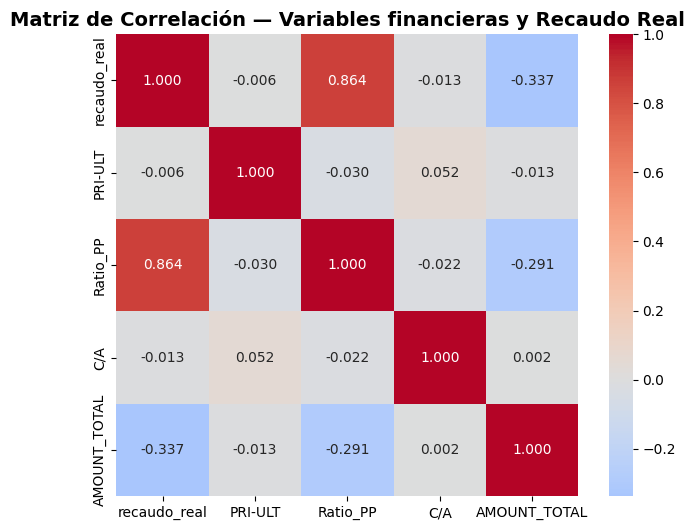

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- columnas que nos interesan ---
cols_corr = ["recaudo_real", "PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]

# --- filtrar solo las que existan ---
df_corr = df[[c for c in cols_corr if c in df.columns]].copy()

# --- calcular matriz de correlación ---
corr_matrix = df_corr.corr(method='pearson')

print("✅ Matriz de correlación (coeficiente de Pearson):")
display(corr_matrix)

# --- visualizar heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0, square=True)
plt.title("Matriz de Correlación — Variables financieras y Recaudo Real", fontsize=14, weight="bold")
plt.show()

📈 Correlaciones individuales con 'recaudo_real':


Ratio_PP        0.863762
PRI-ULT        -0.006034
C/A            -0.012888
AMOUNT_TOTAL   -0.337170
Name: recaudo_real, dtype: float64

/tmp/ipykernel_2192/577039753.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")


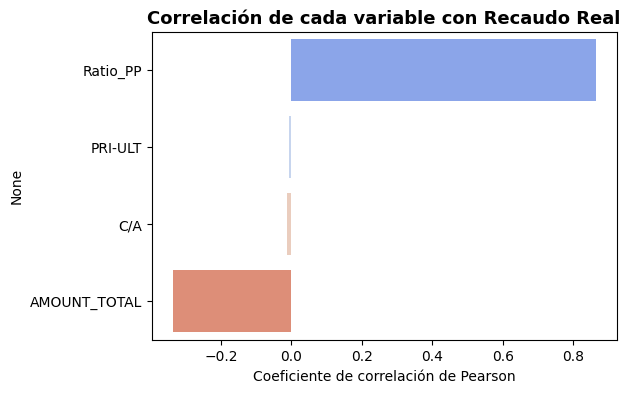

In [11]:
# --- correlaciones individuales con la variable objetivo ---
target_corr = corr_matrix["recaudo_real"].drop("recaudo_real").sort_values(ascending=False)
print("📈 Correlaciones individuales con 'recaudo_real':")
display(target_corr)

# Si quieres graficarlo:
plt.figure(figsize=(6,4))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Correlación de cada variable con Recaudo Real", fontsize=13, weight="bold")
plt.xlabel("Coeficiente de correlación de Pearson")
plt.show()

🌲 Importancia de variables según Random Forest:


AMOUNT_TOTAL    0.819788
Ratio_PP        0.161115
C/A             0.014339
PRI-ULT         0.004758
dtype: float64

/tmp/ipykernel_2192/4114602934.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias.values, y=importancias.index, palette="viridis")


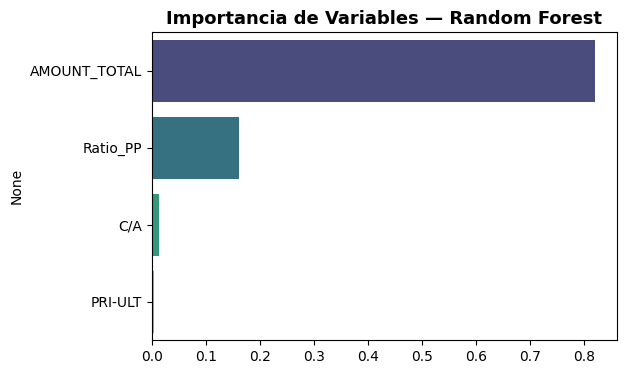

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df[["PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]]
y = df["recaudo_real"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importancias = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("🌲 Importancia de variables según Random Forest:")
display(importancias)

plt.figure(figsize=(6,4))
sns.barplot(x=importancias.values, y=importancias.index, palette="viridis")
plt.title("Importancia de Variables — Random Forest", fontsize=13, weight="bold")
plt.show()

# CALCULADORA

#Análisis descriptivo básico de las variables

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- columnas clave ---
cols = ["recaudo_real", "PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]

# --- descripción estadística ---
desc = df[cols].describe().T
desc["skew"] = df[cols].skew()
desc["kurt"] = df[cols].kurt()
display(desc.style.background_gradient(cmap="Purples", axis=0))

,count,mean,std,min,25%,50%,75%,max,skew,kurt
recaudo_real,4585.000000,0.068838,0.229160,0.000000,0.001190,0.001190,0.011900,1.000000,3.683214,11.901469
PRI-ULT,4585.000000,4.004144,5.875544,1.000000,2.000000,3.000000,5.000000,121.000000,10.855934,167.502360
Ratio_PP,4582.000000,0.042893,0.170561,0.000000,0.000362,0.001190,0.003832,1.000000,4.768099,22.452136
C/A,4585.000000,0.656223,1.302417,0.000000,0.154612,0.440501,0.764042,37.718012,12.062811,230.660740
AMOUNT_TOTAL,4585.000000,273291795.192493,227351181.246772,7058.823529,98172445.460000,204518042.500000,418727491.000000,840240096.100000,0.812573,-0.375678


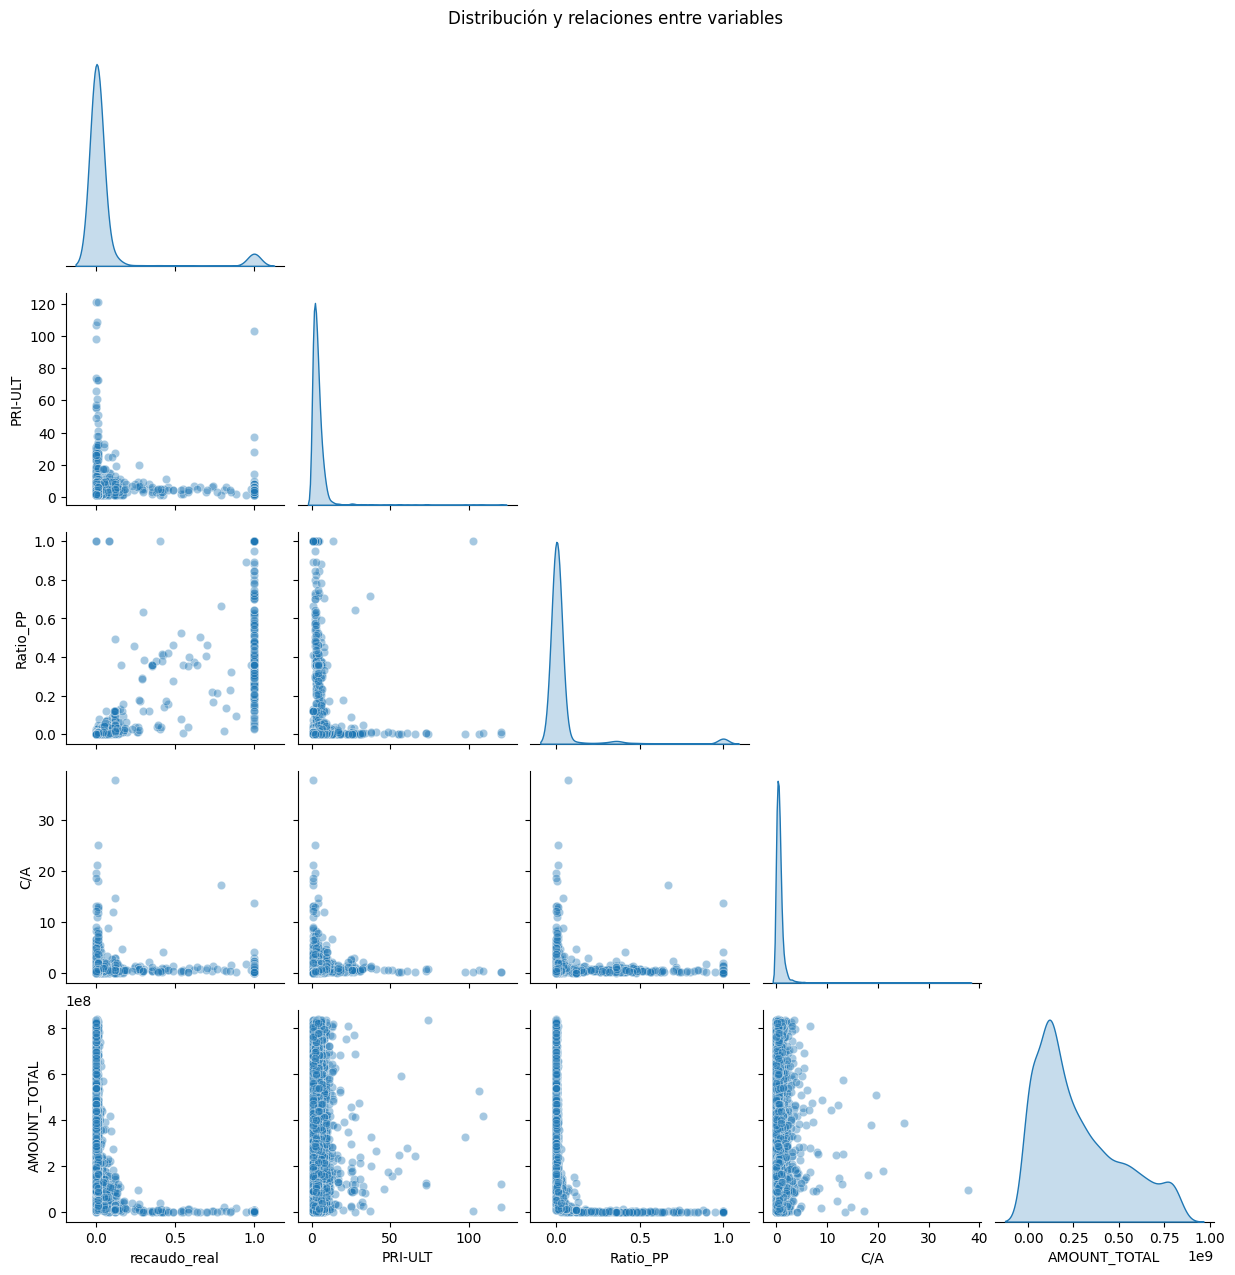

In [14]:
sns.pairplot(df[cols], diag_kind="kde", corner=True, plot_kws={'alpha':0.4})
plt.suptitle("Distribución y relaciones entre variables", y=1.02)
plt.show()

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

# --- columnas clave ---
cols = ["PRI-ULT","Ratio_PP","C/A","AMOUNT_TOTAL"]

# --- imputar valores faltantes con la mediana ---
imputer = SimpleImputer(strategy="median")
X_num = pd.DataFrame(imputer.fit_transform(df[cols]), columns=cols)

# --- generar variables polinómicas para explorar no linealidad ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_num)

# --- calcular VIF para medir colinealidad ---
vif = pd.DataFrame()
vif["Feature"] = cols
vif["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print("✅ Varianza Inflacionaria (VIF):")
display(vif.style.background_gradient(cmap="Purples", axis=0))

✅ Varianza Inflacionaria (VIF):


,Feature,VIF
0,PRI-ULT,1.272939
1,Ratio_PP,1.020751
2,C/A,1.177004
3,AMOUNT_TOTAL,1.314200


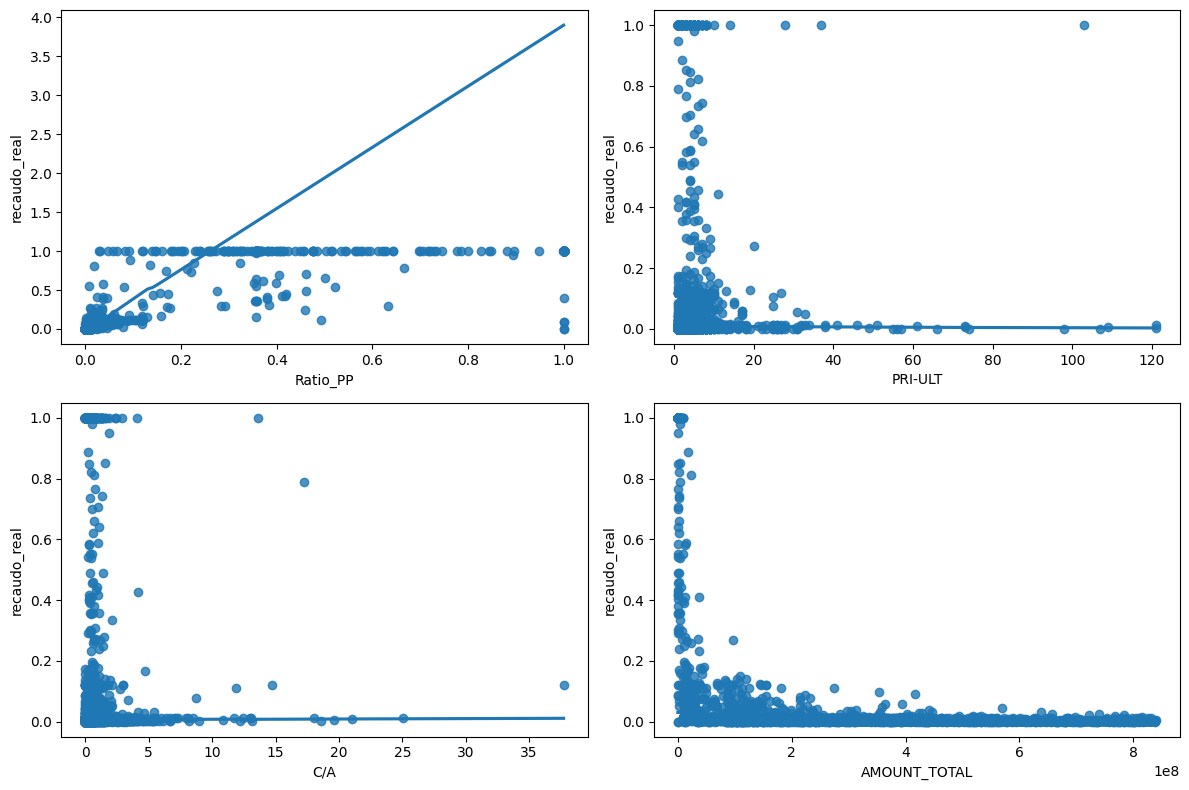

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.regplot(data=df, x="Ratio_PP", y="recaudo_real", lowess=True, ax=axes[0,0])
sns.regplot(data=df, x="PRI-ULT", y="recaudo_real", lowess=True, ax=axes[0,1])
sns.regplot(data=df, x="C/A", y="recaudo_real", lowess=True, ax=axes[1,0])
sns.regplot(data=df, x="AMOUNT_TOTAL", y="recaudo_real", lowess=True, ax=axes[1,1])
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ============== 1) Preparación robusta de datos ==============
features = ["PRI-ULT","Ratio_PP","C/A","AMOUNT_TOTAL"]
target = "recaudo_real"

# Asegurar numéricos (convierte strings a NaN si no son parseables)
df_num = df.copy()
for c in features + [target]:
    if c in df_num.columns:
        df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

# Separar X, y (sin perder observaciones; imputaremos luego)
X = df_num[features]
y = df_num[target]

# (Opcional) Si tu y debe estar en [0,1], puedes recortar:
# y = y.clip(0, 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ============== 2) Pipelines con imputación + escalado ==============
prepro = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
]

pipe_lin = Pipeline(prepro + [("model", LinearRegression())])

pipe_mlp = Pipeline(prepro + [("model", MLPRegressor(
    hidden_layer_sizes=(64,32,16),
    activation="tanh",
    max_iter=5000,
    random_state=42,
    early_stopping=True
))])

# ============== 3) Entrenamiento y evaluación ==============
pipe_lin.fit(X_train, y_train)
pred_lin = pipe_lin.predict(X_test)

pipe_mlp.fit(X_train, y_train)
pred_mlp = pipe_mlp.predict(X_test)

# Si tu objetivo es fraccional, puedes asegurar límites:
# pred_lin = np.clip(pred_lin, 0, 1)
# pred_mlp = np.clip(pred_mlp, 0, 1)

def evaluar(y_true, y_pred, nombre):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{nombre:>8s} -> MAE: {mae:.6f} | R²: {r2:.6f}")

print("✅ Resultados hold-out (20%):")
evaluar(y_test, pred_lin, "Linear")
evaluar(y_test, pred_mlp, "MLP")

✅ Resultados hold-out (20%):
  Linear -> MAE: 0.045201 | R²: 0.708898
     MLP -> MAE: 0.026348 | R²: 0.859509


#preprocesamiento

In [18]:
import numpy as np

X_adj = X.copy()
X_adj["C/A_log"] = np.log1p(X_adj["C/A"])
X_adj["AMOUNT_TOTAL_log"] = np.log1p(X_adj["AMOUNT_TOTAL"])

# Eliminamos las originales solo si ya no las queremos usar
X_adj = X_adj.drop(columns=["C/A", "AMOUNT_TOTAL"])

In [19]:
from scipy.stats import mstats

for col in ["C/A_log", "AMOUNT_TOTAL_log"]:
    if X_adj[col].max() > X_adj[col].quantile(0.995):  # outliers detectados
        X_adj[col] = mstats.winsorize(X_adj[col], limits=[0.005, 0.005])

In [20]:
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

pipe_mlp_robust = Pipeline([
    ("scaler", RobustScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=2000,
                         random_state=42))
])

#Entrenamiento y prueba

In [21]:
from sklearn.model_selection import train_test_split

y = df["recaudo_real"]
X_train, X_test, y_train, y_test = train_test_split(
    X_adj, y, test_size=0.2, random_state=42
)

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------
# 1) Preparación robusta X_adj
# ---------------------------
features = ["PRI-ULT","Ratio_PP","C/A","AMOUNT_TOTAL"]
target = "recaudo_real"

# Asegura que todo sea numérico (cualquier texto => NaN)
df_num = df.copy()
for c in features + [target]:
    if c in df_num.columns:
        df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

X = df_num[features]
y = df_num[target]

# Log-transform para colas largas
X_adj = X.copy()
X_adj["C/A_log"] = np.log1p(X_adj["C/A"])
X_adj["AMOUNT_TOTAL_log"] = np.log1p(X_adj["AMOUNT_TOTAL"])
X_adj = X_adj.drop(columns=["C/A","AMOUNT_TOTAL"])

# Winsorización *sin* masked arrays (clip a cuantiles, ignora NaN)
def winsorize_series(s, lower=0.005, upper=0.005):
    lo = s.quantile(lower)
    hi = s.quantile(1 - upper)
    return s.clip(lower=lo, upper=hi)

for col in ["C/A_log", "AMOUNT_TOTAL_log"]:
    p995 = X_adj[col].quantile(0.995)
    if X_adj[col].max(skipna=True) > p995:
        X_adj[col] = winsorize_series(X_adj[col], 0.005, 0.005)

# Chequeo rápido de NaN antes del pipeline (es normal que existan, los imputaremos)
print("NaN por columna en X_adj antes de imputar:")
print(X_adj.isna().sum())

# ---------------------------
# 2) Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_adj, y, test_size=0.2, random_state=42
)

# ---------------------------
# 3) Pipeline: Imputer + RobustScaler + MLP
# ---------------------------
pipe_mlp_robust = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # <-- quita NaN
    ("scaler", RobustScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=3000,
        early_stopping=True,
        random_state=42
    ))
])

# ---------------------------
# 4) Entrenar y evaluar
# ---------------------------
pipe_mlp_robust.fit(X_train, y_train)
y_pred = pipe_mlp_robust.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n✅ Desempeño MLP robusto (log + winsor + imputación + robust scaling)")
print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²  : {r2:.6f}")

NaN por columna en X_adj antes de imputar:
PRI-ULT             0
Ratio_PP            3
C/A_log             0
AMOUNT_TOTAL_log    0
dtype: int64



✅ Desempeño MLP robusto (log + winsor + imputación + robust scaling)
MAE : 0.031186
RMSE: 0.088123
R²  : 0.845900


In [23]:
import numpy as np
import pandas as pd

# ===== Utilidades de rango (p1–p99) desde tus datos =====
def _rangos_plausibles(df):
    r = {}
    r["PRI-ULT"] = (float(df["PRI-ULT"].quantile(0.01)), float(df["PRI-ULT"].quantile(0.99)))
    r["Ratio_PP"] = (max(0.0, float(df["Ratio_PP"].quantile(0.01))), min(1.0, float(df["Ratio_PP"].quantile(0.99))))
    r["C/A"] = (max(0.0, float(df["C/A"].quantile(0.01))), float(df["C/A"].quantile(0.99)))
    r["AMOUNT_TOTAL"] = (max(0.0, float(df["AMOUNT_TOTAL"].quantile(0.01))), float(df["AMOUNT_TOTAL"].quantile(0.99)))
    return r

_RANGOS = _rangos_plausibles(df)

def _clip_inputs(pri, ratio, ca, amt):
    pri = float(np.clip(pri, *_RANGOS["PRI-ULT"]))
    ratio = float(np.clip(ratio, *_RANGOS["Ratio_PP"]))
    ca = float(np.clip(ca, *_RANGOS["C/A"]))
    amt = float(np.clip(amt, *_RANGOS["AMOUNT_TOTAL"]))
    return pri, ratio, ca, amt

# ===== Predicción con el pipeline robusto =====
def _predecir(pri, ratio, ca, amt):
    X_new = pd.DataFrame({
        "PRI-ULT": [pri],
        "Ratio_PP": [ratio],
        "C/A_log": [np.log1p(ca)],
        "AMOUNT_TOTAL_log": [np.log1p(amt)]
    })
    yhat = float(np.clip(pipe_mlp_robust.predict(X_new)[0], 0, 1))
    return yhat

# ===== Búsqueda dirigida por correlaciones =====
def _buscar_mejor(pri0, ratio0, ca0, amt, objetivo):
    """
    Grid dirigido:
      - Ratio_PP: barrido hacia ARRIBA
      - PRI-ULT: barrido hacia ABAJO
      - C/A:     barrido hacia ABAJO
    Límites: percentiles 1–99; pasos adaptativos.
    """
    pri_lo, pri_hi = _RANGOS["PRI-ULT"]
    r_lo, r_hi = _RANGOS["Ratio_PP"]
    ca_lo, ca_hi = _RANGOS["C/A"]

    # Construimos rejillas con sesgo en la dirección "buena"
    pri_grid   = np.linspace(pri0, pri_lo, 8)            # bajar
    ratio_grid = np.linspace(ratio0, min(r_hi, max(ratio0, 0.9)), 8)  # subir
    ca_grid    = np.linspace(ca0, max(ca_lo, 0.0), 8)    # bajar

    # Asegurar límites
    pri_grid   = np.clip(pri_grid, pri_lo, pri_hi)
    ratio_grid = np.clip(ratio_grid, r_lo, r_hi)
    ca_grid    = np.clip(ca_grid, ca_lo, ca_hi)

    mejor = {"diff": 1e9, "pri": pri0, "ratio": ratio0, "ca": ca0, "pred": _predecir(pri0, ratio0, ca0, amt)}

    # Búsqueda 3D ligera
    for pri in pri_grid:
        for ratio in ratio_grid:
            for ca in ca_grid:
                pred = _predecir(pri, ratio, ca, amt)
                diff = abs(pred - objetivo)
                if diff < mejor["diff"]:
                    mejor = {"diff": diff, "pri": float(pri), "ratio": float(ratio), "ca": float(ca), "pred": float(pred)}
                    if diff <= 0.005:  # muy cerca, corta temprano
                        return mejor
    return mejor

def calcular_recaudo_y_recomendar(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL):
    """
    Predice recaudo_real y sugiere valores "óptimos" de
    PRI-ULT, Ratio_PP y C/A para alcanzar 0.7, 0.8 y 0.9,
    respetando rangos plausibles observados en tus datos.
    """
    # 1) Asegurar entradas dentro de rangos plausibles
    PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL = _clip_inputs(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL)

    # 2) Predicción actual
    pred_actual = _predecir(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL)
    print(f"🔮 Recaudo estimado actual: {pred_actual:.3f}")

    # 3) Buscar mejores combinaciones por objetivo
    objetivos = [0.7, 0.8, 0.9]
    print("\n🎯 Recomendaciones para alcanzar objetivos:")
    for obj in objetivos:
        if pred_actual >= obj:
            print(f"\nObjetivo {obj:.1f}: ✅ ya estás en {pred_actual:.3f}. Mantén la trayectoria actual.")
            continue

        mejor = _buscar_mejor(PRI_ULT, Ratio_PP, C_A, AMOUNT_TOTAL, obj)
        print(f"\nObjetivo {obj:.1f} → pred alcanzada: {mejor['pred']:.3f} (Δ={abs(mejor['pred']-obj):.3f})")
        print(f"  ▪ PRI-ULT  → {mejor['pri']:.2f}  (bajar suele ayudar)")
        print(f"  ▪ Ratio_PP → {mejor['ratio']:.3f} (subir suele ayudar)")
        print(f"  ▪ C/A      → {mejor['ca']:.3f}  (bajar suele ayudar)")

    # 4) Guía textual coherente con la correlación observada
    print("\n💡 Consejos automáticos (según correlaciones empíricas):")
    if pred_actual < 0.7:
        print("- Enfócate en SUBIR Ratio_PP (≈ 0.6–0.85), BAJAR PRI-ULT y BAJAR C/A.")
    elif pred_actual < 0.8:
        print("- Afina Ratio_PP hacia 0.7–0.85; mantén PRI-ULT bajo; evita C/A alto.")
    else:
        print("- Buen desempeño: Ratio_PP alto y estable, PRI-ULT reducido, C/A moderado.")

# ===== Ejemplo rápido =====
calcular_recaudo_y_recomendar(
    PRI_ULT=5,
    Ratio_PP=0.40,
    C_A=1,
    AMOUNT_TOTAL= 8_500_000
)

🔮 Recaudo estimado actual: 0.658

🎯 Recomendaciones para alcanzar objetivos:

Objetivo 0.7 → pred alcanzada: 0.695 (Δ=0.005)
  ▪ PRI-ULT  → 5.00  (bajar suele ayudar)
  ▪ Ratio_PP → 0.471 (subir suele ayudar)
  ▪ C/A      → 0.143  (bajar suele ayudar)

Objetivo 0.8 → pred alcanzada: 0.795 (Δ=0.005)
  ▪ PRI-ULT  → 5.00  (bajar suele ayudar)
  ▪ Ratio_PP → 0.757 (subir suele ayudar)
  ▪ C/A      → 0.714  (bajar suele ayudar)



Objetivo 0.9 → pred alcanzada: 0.859 (Δ=0.041)


  ▪ PRI-ULT  → 5.00  (bajar suele ayudar)
  ▪ Ratio_PP → 0.900 (subir suele ayudar)
  ▪ C/A      → 0.000  (bajar suele ayudar)

💡 Consejos automáticos (según correlaciones empíricas):
- Enfócate en SUBIR Ratio_PP (≈ 0.6–0.85), BAJAR PRI-ULT y BAJAR C/A.


In [24]:
import os, json, pandas as pd, gspread
from google.oauth2.service_account import Credentials

# === Cargar credenciales de manera segura (Colab, GitHub o local) ===
def load_creds():
    try:
        from google.colab import userdata
        mi_json = userdata.get("MI_JSON")
        if mi_json:
            info = json.loads(mi_json)
            return Credentials.from_service_account_info(info, scopes=[
                "https://spreadsheets.google.com/feeds",
                "https://www.googleapis.com/auth/drive"
            ])
    except Exception:
        pass

    if os.getenv("MI_JSON"):
        info = json.loads(os.environ["MI_JSON"])
        return Credentials.from_service_account_info(info, scopes=[
            "https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive"
        ])

    if os.path.exists("MI_JSON.json"):
        return Credentials.from_service_account_file("MI_JSON.json", scopes=[
            "https://spreadsheets.google.com/feeds",
            "https://www.googleapis.com/auth/drive"
        ])

    raise RuntimeError("No se encontró MI_JSON (ni en secrets ni local).")

# === Inicializar conexión ===
cred = load_creds()
gc = gspread.authorize(cred)

# === Leer hoja “Saldos” (ignora mayúsculas) ===
url = "https://docs.google.com/spreadsheets/d/1ynZ6TvYvhGeCdgqXwZBwPQPppWSUkcEnRHDyey59LzI/edit?gid=675083255#gid=675083255"
spreadsheet = gc.open_by_url(url)
worksheet = next(ws for ws in spreadsheet.worksheets() if ws.title.lower() in ["saldos", "saldo"])

# === Descargar datos ===
data = worksheet.get_all_records()
df_saldo = pd.DataFrame(data)

print(f"✅ Hoja '{worksheet.title}' leída con {len(df_saldo)} filas.")
print(df_saldo.head().to_string(index=False))

✅ Hoja 'saldos' leída con 202000 filas.
 Referencia    Saldo
 3112461212 56553858
 3028623442 56122824
 3012083363 44686306
 3108649506 39780853
 3245501243 34249170


In [25]:
# Convertir tipos de datos
df_saldo["Referencia"] = df_saldo["Referencia"].astype(str).astype("object")
df_saldo["Saldo"] = pd.to_numeric(df_saldo["Saldo"], errors="coerce")

# Verificar tipos de datos
df_saldo.dtypes

Referencia    object
Saldo          int64
dtype: object

In [26]:
df_saldo

,Referencia,Saldo
0,3112461212,56553858
1,3028623442,56122824
2,3012083363,44686306
3,3108649506,39780853
4,3245501243,34249170
...,...,...
201995,0,0
201996,0,0
201997,0,0
201998,0,0


In [27]:
# Unir los DataFrames por la columna 'Referencia'
cartera_asignada_filtrada = cartera_asignada_filtrada.merge(
    df_saldo[["Referencia", "Saldo"]],
    on="Referencia",
    how="left"   # mantiene todas las filas de cartera_asignada_filtrada
)

# Verificar resultado
cartera_asignada_filtrada.head()

,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual,Saldo
0,3148617478,1245261,0.20,Bancamia S.A,4646250.0,837782.77,237689.68,NaN
1,3185312961,932389,0.15,CREDIVALORES,4106764.0,897644.21,335930.69,NaN
2,3118577144,913615,0.15,Serfinanza,3093200.0,483632.95,159866.56,5667.0
3,3014258268,1246580,0.15,Bancolombia,5506600.0,324344.81,86409.23,338798.0
4,3125824831,1049698,0.15,Falabella,3357110.0,622761.09,191919.99,NaN


In [28]:
cartera_asignada_filtrada

,Referencia,Id deuda,CE,Banco,Deuda Resuelve,Apartado Mensual,Comisión Mensual,Saldo
0,3148617478,1245261,0.20,Bancamia S.A,4646250.0,837782.77,237689.68,NaN
1,3185312961,932389,0.15,CREDIVALORES,4106764.0,897644.21,335930.69,NaN
2,3118577144,913615,0.15,Serfinanza,3093200.0,483632.95,159866.56,5667.0
3,3014258268,1246580,0.15,Bancolombia,5506600.0,324344.81,86409.23,338798.0
4,3125824831,1049698,0.15,Falabella,3357110.0,622761.09,191919.99,NaN
...,...,...,...,...,...,...,...,...
44755,3245662858,1993803,0.15,AECSA Davivienda,15040200.0,757940.75,162528.42,215.0
44756,3155332043,1990015,0.15,Zinobe,552200.0,509833.44,134709.19,211.0
44757,3155332043,1990017,0.15,JOHN F. KENNEDY,19404000.0,509833.44,134709.19,211.0
44758,3155332043,1990016,0.15,BBVA,583000.0,509833.44,134709.19,211.0


In [29]:
from pathlib import Path

# Crear carpeta "data" si no existe
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)

# Guardar la base en formato Parquet y CSV
cartera_asignada_filtrada.to_parquet(out_dir / "cartera_asignada_filtrada.parquet", index=False)
cartera_asignada_filtrada.to_csv(out_dir / "cartera_asignada_filtrada.csv", index=False, encoding="utf-8")

print("✅ Base guardada en data/cartera_asignada_filtrada.parquet y .csv")

✅ Base guardada en data/cartera_asignada_filtrada.parquet y .csv


#DESCARGAR MODELO

In [30]:
# ==== A.1: Imports y utilidades (READY PARA GITHUB ACTIONS) ====
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import sys, platform

# ==== A.2: Datos esperados ====
# df debe existir y contener estas columnas + el target:
FEATURES_RAW = ["PRI-ULT", "Ratio_PP", "C/A", "AMOUNT_TOTAL"]
TARGET = "recaudo_real"

# Validación básica
faltantes = [c for c in FEATURES_RAW + [TARGET] if c not in df.columns]
if faltantes:
    raise ValueError(f"Faltan columnas en df: {faltantes}. Están: {list(df.columns)}")

# Asegura tipos numéricos
df_num = df.copy()
for c in FEATURES_RAW + [TARGET]:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
df_num = df_num.dropna(subset=FEATURES_RAW + [TARGET]).reset_index(drop=True)

X = df_num[FEATURES_RAW].copy()
y = df_num[TARGET].astype(float).values

# ==== A.3: Transformadores custom (idénticos a app.py) ====
class LogAndDrop(BaseEstimator, TransformerMixin):
    """
    Crea columnas log1p de ['C/A', 'AMOUNT_TOTAL'] y elimina las originales.
    Mantiene ['PRI-ULT','Ratio_PP'] tal cual.
    Salida: ['PRI-ULT','Ratio_PP','C/A_log','AMOUNT_TOTAL_log']
    """
    def __init__(self, ca_col="C/A", amt_col="AMOUNT_TOTAL"):
        self.ca_col = ca_col
        self.amt_col = amt_col
        self.out_feature_names_ = ["PRI-ULT", "Ratio_PP", "C/A_log", "AMOUNT_TOTAL_log"]
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X["C/A_log"] = np.log1p(pd.to_numeric(X[self.ca_col], errors="coerce").astype(float))
        X["AMOUNT_TOTAL_log"] = np.log1p(pd.to_numeric(X[self.amt_col], errors="coerce").astype(float))
        X = X.drop(columns=[self.ca_col, self.amt_col])
        return X[["PRI-ULT", "Ratio_PP", "C/A_log", "AMOUNT_TOTAL_log"]]
    def get_feature_names_out(self, input_features=None):
        return np.array(self.out_feature_names_)

class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Winsoriza por cuantiles (p_low, p_high) columnas numéricas.
    Aprende límites en fit y los aplica en transform.
    """
    def __init__(self, columns=None, p_low=0.005, p_high=0.005):
        self.columns = columns or []
        self.p_low = p_low
        self.p_high = p_high
        self.lows_ = {}
        self.highs_ = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X, copy=True)
        for c in self.columns:
            s = pd.to_numeric(X[c], errors="coerce")
            self.lows_[c] = float(s.quantile(self.p_low))
            self.highs_[c] = float(s.quantile(1 - self.p_high))
        return self
    def transform(self, X):
        X = pd.DataFrame(X, copy=True)
        for c in self.columns:
            lo = self.lows_[c]; hi = self.highs_[c]
            X[c] = pd.to_numeric(X[c], errors="coerce").clip(lower=lo, upper=hi)
        return X

# ==== A.4: Split reproducible ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==== A.5: Pipeline completo (pre + imputación + robust + MLP) ====
pipe_mlp_robust = Pipeline(steps=[
    ("log_and_drop", LogAndDrop(ca_col="C/A", amt_col="AMOUNT_TOTAL")),
    ("winsor", Winsorizer(columns=["C/A_log", "AMOUNT_TOTAL_log"], p_low=0.005, p_high=0.005)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=3000,
        early_stopping=True,
        random_state=42
    ))
])

pipe_mlp_robust.fit(X_train, y_train)

# ==== A.5.1: Evaluación y log ====
y_pred = pipe_mlp_robust.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n✅ Desempeño MLP robusto")
print(f"MAE : {mae:,.6f}")
print(f"RMSE: {rmse:,.6f}")
print(f"R²  : {r2:,.6f}")
print(f"Python: {sys.version.split()[0]} | NumPy: {np.__version__}")

# ==== A.6: Guardar artefactos (para que los comitee el Action) ====
# Guarda en la raíz (tu app.py ya los carga desde ahí)
joblib.dump(pipe_mlp_robust, "mlp_recaudo_pipeline.joblib")

meta = {
    "feature_order_raw": FEATURES_RAW,
    "target": TARGET,
    "metrics": {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)},
    "notes": "Pipeline: Log1p(C/A,AMOUNT_TOTAL)+winsor(0.5%)+imputer(median)+RobustScaler+MLP(64,32)",
    "versions": {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "sklearn": __import__("sklearn").__version__,
        "joblib": joblib.__version__,
    }
}
with open("mlp_recaudo_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("✅ Guardados: mlp_recaudo_pipeline.joblib, mlp_recaudo_meta.json (listos para commit)")


✅ Desempeño MLP robusto
MAE : 0.026845
RMSE: 0.083434
R²  : 0.837807
Python: 3.10.19 | NumPy: 2.0.2
✅ Guardados: mlp_recaudo_pipeline.joblib, mlp_recaudo_meta.json (listos para commit)
